# Time Series - Models

We have already covered Moving, smoothing, Holt-Winters, etc. in the previous notebook.

In this we will cover easier models to work with at the same time without compromising the score much.

- Linear Regression
- Ridge Model
- Lasso Model 
- XGBoost


Importing required libraries. 

We will use *`statsmodels`* library containing very useful *`statistical`* modeling functions, including ***Time Series***. 

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more beautiful plots
%matplotlib inline

In [2]:
# Set sns to show some standard charectaristics throughout the notebook

sns.set(context='talk', style='darkgrid', palette='deep', 
        font='sans-serif', font_scale=1.2, color_codes=False,
        rc={"lines.linewidth": 2})

#sns.set_context("paper")
#sns.set_context("talk")
#sns.set_context("poster")
#sns.set_context("notebook")

In [3]:
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

In [4]:
from itertools import product                 # some useful functions like cartesian product
from tqdm import tqdm_notebook

import warnings                               # `do not disturbe` mode
warnings.filterwarnings('ignore')

#### Familiarising with the data

In [5]:
df = pd.read_csv('international-airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Let us change the `Month` column to real datetime values suitable for ***Time Series*** data 

In [6]:
df.Month = pd.to_datetime(df.Month)
df.set_index('Month', inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


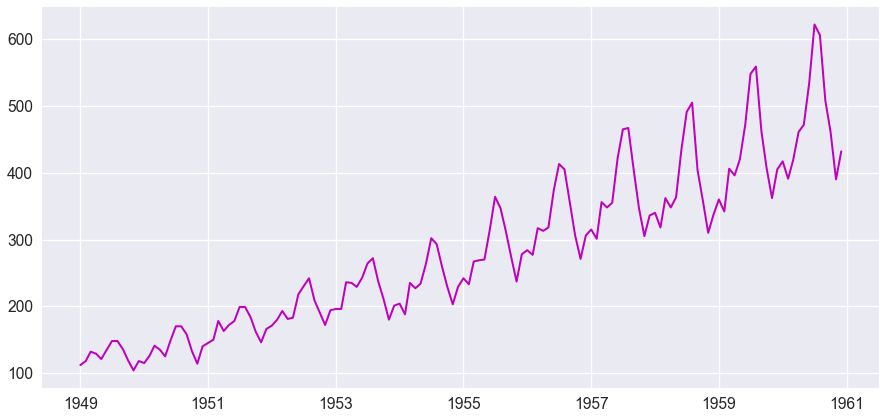

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(df.Passengers, 'm')
plt.show()

## How to measure forecast - quality metrics

- ***Mean Absolute Error***: It has the same unit of measurement as the initial series, [0, +inf)
*`sklearn.metrics.mean_absolute_error`*

- ***Mean Squared Error***: Commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
*`sklearn.metrics.mean_squared_error`*

- ***Mean Squared Logarithmic Error***: Same as MSE but takes logarithm of the series. This allows to pay attention to even small mistakes, usually is used when data has exponential trends, [0, +inf)
*`sklearn.metrics.mean_squared_log_error`*

- ***Mean Absolute Percentage Error***: Same as MAE but percentage - [0, +inf)
    - very convenient to assess the quality of the model 
    - Good for an `Apple-toApple` comparison
    - not implemented in sklearn

In [8]:
# Importing everything from above

from sklearn.metrics import mean_absolute_error, \
                            mean_squared_error,  \
                            mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Sklearn has *`TimeSeriesSplit`* which does the cros validation in a neat way

In [9]:
from sklearn.model_selection import TimeSeriesSplit 

In [10]:
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [11]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Prepare the data with Features and transformations.


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
def prepareData(series, lag_start, lag_end, test_size):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test =\
prepareData(df.Passengers, lag_start=6, lag_end=25, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression


In [16]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

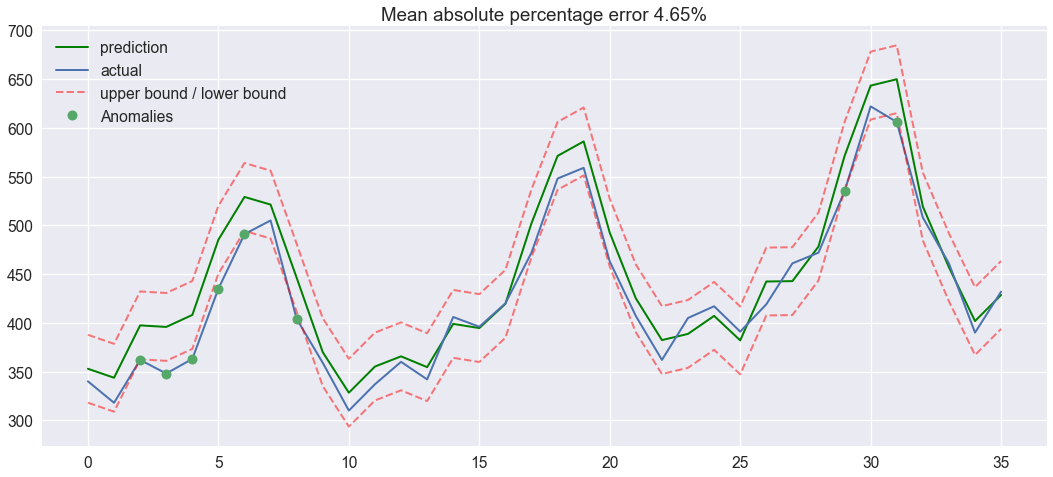

In [18]:
plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
# plotCoefficients(lr)

## Ridge model

In [19]:
from sklearn.linear_model import LassoCV, RidgeCV


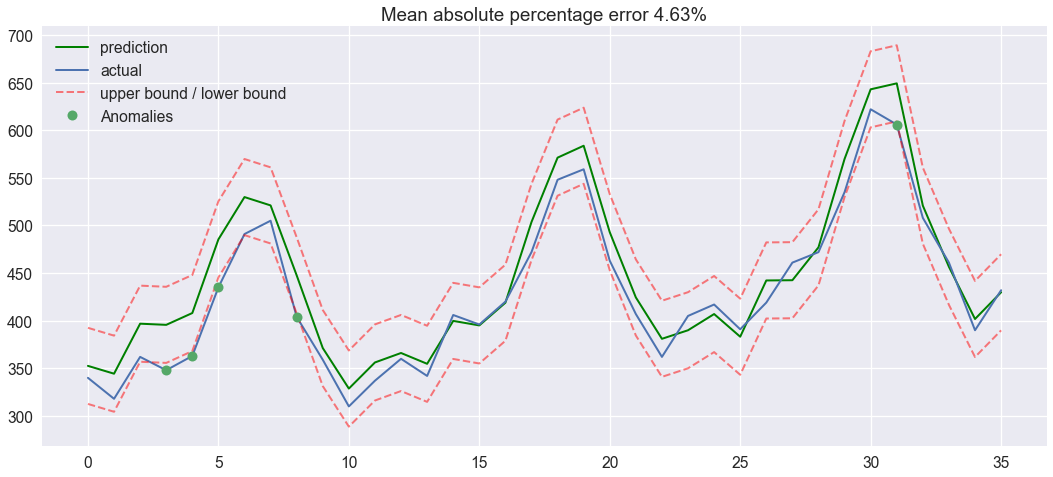

In [20]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
#plotCoefficients(ridge)

## Lasso models

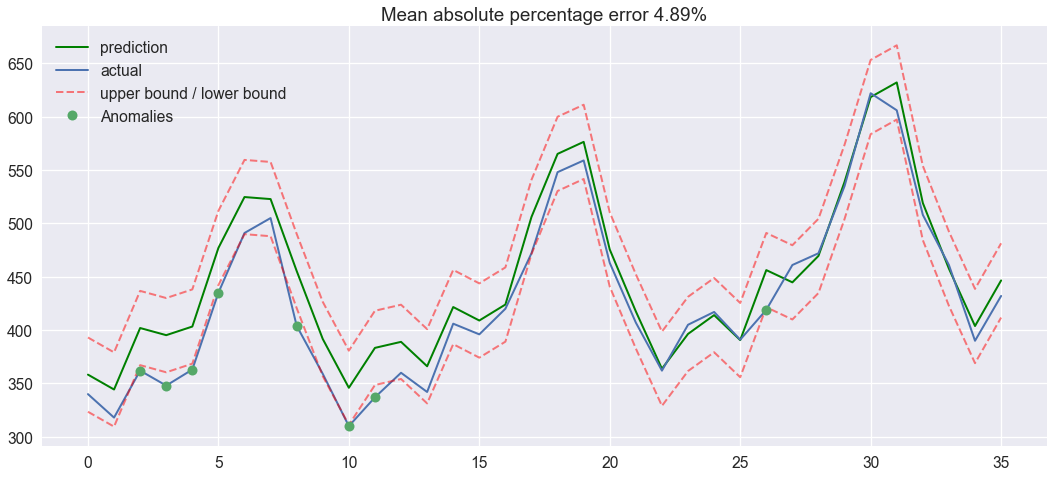

In [21]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
#plotCoefficients(lasso)

## Try XGBoost

In [22]:
import sys
from xgboost import XGBRegressor 

In [23]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, 
        y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

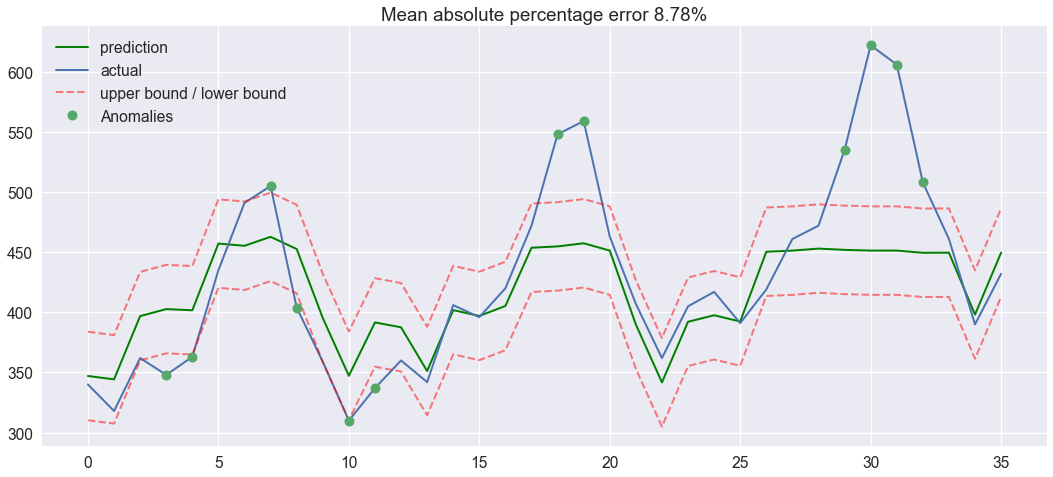

In [24]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)